have to bin on timestamp, not delta -> timedeltas/negative times are treated weirdly and it results in the bins being really different from the v16 analysis

binning on timestamp gives count values exactly the same as v16 analysis

it also gives lick frequencies nearly the same as v16 analysis

### V16 analysis copy

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf as bp
import seaborn as sns
import statsmodels.api as sm
import scipy.stats
import os
import re

import load_data
import analysis_helper

In [3]:
def timefromfile(filename):
    "Convert filename to timestamp for start of trials"
    datetime = re.findall("\d\d_\d\d_\d\d_T_\d\d_\d\d_\d\d", filename)[0]
    datetime = datetime.replace("_", "-", 2).replace("_T_", " ").replace("_", ":")
    return pd.Timestamp(datetime)


def loadfile(filename):
    '''Given a string filename, loads in the data, extracts the start time from the filename, and formats the timestamps based on the start time.'''
    animal = pd.read_csv(filename, header=None)
    animal = animal.rename(columns={0:"timestamp",1:"poke", 2:"lick", 3:"water", 4:"delay"})
    datetime = timefromfile(filename)
    animal["timestamp"] = pd.to_datetime(animal["timestamp"], unit="s", origin=pd.Timestamp(datetime))
    animal["time (ms)"] = datetime
    animal["delay"] = pd.to_timedelta(animal["delay"], unit="ms")
    return animal.iloc[:, 0:5]

def getTrials (tp):
    (idx, x) = tp
    return pd.Series([idx for i in range(x)], dtype="int")

def labelTrials (animal):
    '''Given the set of data for an animal, labels each sample in a trial with the trial type and the trial number, numbering trials consecutively from 1.
    The number of trials, and the number of each trial type, matches v16 of the matlab analysis.
    '''
    #first sample for each new trial - current water code is not 7 (timeout) and previous is 7 plus first and last sample (for diff alignment)
    trial_boundaries = pd.concat([animal.iloc[[0]], animal[(animal["water"]!=7) & (animal["water"].shift() == 7)], animal.iloc[[animal.shape[0]-1]]])

    trial_count = pd.Series(trial_boundaries.index)    
    #get number of samples per trial (difference in sample number between previous boundary and current boundary)
    trial_count = pd.Series(enumerate(trial_count.diff().fillna(0).astype('int').tolist()))
    #enumerate trial number from first sample to all samples in trial
    trial_count = trial_count.map(getTrials).explode()[1:]
    trial_count.index = range(0, trial_count.shape[0])
    animal.insert(1, "trial no", trial_count)
    #set trial no for last sample
    animal.loc[animal.shape[0] - 1, "trial no",] = trial_boundaries.shape[0] -1

    #label trial types
    go = animal.groupby(["trial no"]).filter(lambda x: (x["water"]==3).any())
    go["trial type"] = ["water" for i in range(go.shape[0])]
    animal["trial type"] = go["trial type"]
    animal["trial type"] = animal["trial type"].fillna(value="blank")
    return animal

def init_data(data, animal, cond):
    '''Set animal and condition and update lick value to binary 1/0'''
    data.loc[data["lick"] == 2,"lick"] = 1
    data["animal"] = animal
    data["condition"] = cond
    return data

def load_sat(pSAT, animals, name, metadata, v16analysis):
    for an in os.listdir(pSAT):
        p = pSAT + "\\" + an
        #guarantees files opened in time order (path list is arbitrary)
        fs = os.listdir(p)
        fs.sort()
        curranimal = []
        print(an)
        for f in fs:
            if (os.path.isfile(p + "\\" + f)):      
                curranimal.append(loadfile(p + "\\" + f))
            if(f == "analysis"):
                for fle in os.listdir(p + "\\" + f):                
                    if "ForPlotting" in fle:
                        plt = pd.read_excel(p + "\\" + f + "\\" + fle)
                        plt["animal"] = an
                        plt["condition"] = name
                        v16analysis = pd.concat([v16analysis, plt])
        #all files concatenated in order
        curranimal = labelTrials(pd.concat(curranimal, ignore_index=True))
        if (metadata[metadata["Animal ID"] == an].empty):
            curranimal["acc"] = pd.to_timedelta(1, unit="D")
        else:
            acc_days = metadata[metadata["Animal ID"] == an].reset_index()["Acclimation (days)"][0]
            if an == "NDR1":
                acc_days = acc_days + 1
            curranimal["acc"] = pd.to_timedelta(acc_days, unit="D")            
        curranimal = init_data(curranimal, an, name)
        animals = pd.concat([animals, curranimal])
    return (animals, v16analysis)

def load_100(animals, path_100_80, v16analysis):
    #100 80 SAT directory
    for d in os.listdir(path_100_80):
        p = path_100_80 + "\\" + d
        #animal directory (path list is arbitrary)
        andirs = os.listdir(p)
        andirs = sorted(andirs, key=str.lower)
        curranimal = []
        print(d)
        for d2 in andirs:
            p2 = p + "\\" + d2
            #acc/SAT - sort if multiple files
            fs = os.listdir(p2)
            fs.sort()  
            for f in fs:            
                if os.path.isfile(p2 + "\\" + f):
                    curranimal.append(loadfile(p2 + "\\" + f))
                if(f == "analysis"):
                    for fle in os.listdir(p2 + "\\" + f):                
                        if "ForPlotting" in fle:
                            plt = pd.read_excel(p2 + "\\" + f + "\\" + fle)
                            plt["animal"] = d
                            plt["condition"] = "100%"                        
                            if "allreward" in fle:
                                plt.loc[:, "Time Bin (hr)"] = plt.loc[:, "Time Bin (hr)"] - 24
                            if ("temptest" in fle) & (d in ["NLV5", "NLV2", "NLV3", "NLN3", "NLN5", "NLB1"]):
                                plt.loc[:, "Time Bin (hr)"] = plt.loc[:, "Time Bin (hr)"] + 24
                            v16analysis = pd.concat([v16analysis, plt])
        #all files concatenated in order   
        curranimal = labelTrials(pd.concat(curranimal, ignore_index=True))
        curranimal["acc"] = pd.to_timedelta(1, unit="D")
        curranimal = init_data(curranimal, d, "100%")
        
        animals = pd.concat([animals, curranimal])
    return (animals, v16analysis)

def load_all_data(SATpaths, path_100_80, metadata):
    animals = pd.DataFrame()
    v16analysis = pd.DataFrame()
    for (pSAT, name) in SATpaths:
        print(name)
        an_res, v16_res = load_sat(pSAT, pd.DataFrame(), name, metadata, pd.DataFrame())
        animals = pd.concat([animals, an_res])
        v16analysis = pd.concat([v16analysis, v16_res])
    an_res, v16_res = load_100(pd.DataFrame(), path_100_80, pd.DataFrame())
    animals = pd.concat([animals, an_res])
    v16analysis = pd.concat([v16analysis, v16_res])
    
    animals = animals.set_index(["condition", "animal", "trial no"])

    return (animals, v16analysis)

In [4]:
#load metadata
path_metadata = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\Animal lists.xlsx"
hm4di_metadata = pd.read_excel(path_metadata)
hm4di_metadata[hm4di_metadata["Animal ID"] == "MJn3"]["Acclimation (days)"]
#load data for prelim animals
prelim_path_SAT = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\prelim\\SAT"
prelim_path_100_80 = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\prelim\\100 80 SAT"
prelim, v16analysis = load_all_data([(prelim_path_SAT, "SAT")], prelim_path_100_80, hm4di_metadata)

#load data for all animals
all_SAT = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\all animals\\SAT"
all_100_80 = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\all animals\\100 80"
all_mch = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\all animals\\mcherry"
all_hm4di = "C:\\Users\\swind\\Documents\\lab work\\lab work barth\\behavior analysis\\Eunsol data\\all animals\\hM4Di SAT"
all_animals, v16analysis = load_all_data([(all_SAT, "SAT"), (all_mch, "mcherry"), (all_hm4di, "hm4di")], all_100_80, hm4di_metadata)
all_animals = all_animals.reset_index()
all_animals = all_animals[(all_animals["animal"] != "JOV1")].set_index(["condition", "animal", "trial no"])

#load v16 analysis
v16analysis.loc[v16analysis["animal"] == "NCY6"] = v16analysis[v16analysis["animal"] == "NCY6"].iloc[0:12]

SAT
GSB8
GXS5
JSS4
NJO1
NLB10
NLB8
NLG3
NLN3
SAT
GKO6
GSB8
GXC7
GXS4
GXS5
JND2
JOV1
JSS4
NFZ13
NFZ4
NGX5
NJO1
mcherry
MJL2
MJN2
MJN3
MJN5
MYC4
MZG4
MZG5
NBE11
NCY1
NCY4
NCY6
NDR1
NIO15
NIO16
hm4di
LWP2
LWP4
LWP6
LWP8
MKV10
MKV11
MKV14
NAS9
NBX7
NBX9
NEJ1
NJW5
NKZ10
NKZ3
NKZ4
NKZ7
NLB1
NLB10
NLB3
NLB8
NLG3
NLN3
NLN5
NLV2
NLV3
NLV5


In [5]:
aa = all_animals.reset_index()
aa = analysis_helper.delta(aa, "timestamp")
aa = analysis_helper.trialdelta(aa)
aa = analysis_helper.deliverydelta(aa)

In [37]:
antlick = analysis_helper.thresh(aa, 700, 1000, True, True)

group = antlick.groupby(["condition", "animal", "trial no", "trial type"])
freqs = (pd.concat([group["lick"].sum()/0.3, group["delta"].first(), group["timestamp"].mean(), group["acc"].first()], axis=1)).reset_index()
freqs = freqs.set_index("timestamp")

binned = freqs.groupby(["condition", "animal", pd.Grouper(freq="4H"), "trial type"])
licks = pd.concat([binned["lick"].mean(), binned["acc"].first()], axis=1)

counts = freqs.groupby(["condition", "animal", pd.Grouper(freq="4H")])["trial no"].count().rename("count").reset_index()
counts["trial type"] = "perf"
counts = counts.set_index(["condition", "animal", "timestamp"])


acc = licks.groupby(["condition", "animal"]).first()["acc"]

lk_group = licks.groupby(["condition", "animal", "timestamp", "trial type"])
#mean lick/poke frequency and trial counts for each bin
perf = lk_group[["lick"]].mean().unstack(level="trial type")
#calculate performance (water - blank) for licks
perf.loc[:, "perf"] = perf.loc[:, ("lick", "water")] - perf.loc[:,("lick", "blank")]
perf = pd.concat([perf,counts], axis=1).reset_index().set_index(["condition", "animal"])
perf["acc"] = acc
perf["delta"] = perf["timestamp"] - perf.sort_values("timestamp").groupby("animal")["timestamp"].first() - perf.groupby("animal")["acc"].first() + pd.to_timedelta("2h")
perf["delta"] = perf["delta"].astype("timedelta64[h]")
perf = perf.reset_index()

v16_compare = perf.rename(columns={("lick", "blank"):"blank",("lick", "water"):"water",("perf",""):"perf"})[["delta", "water", "blank", "perf", "count",  "animal", "condition"]]


problem animals: 
- NDR1 
- LWP4 (analysis split, annoying to import)
- GKO6 Mason (something weird happening with concat split files)
    - alignment issues

#animals where 1 trial got put into a different timebin: MJN3, MYC4, NCY1, GSB8 Caitlyn, NDR1


In [38]:
#manual timebin adjustment for misaligned animals
v16_compare.loc[v16_compare["animal"] == "MJN2", "delta"] = v16_compare.loc[v16_compare["animal"] == "MJN2", "delta"] + 4 
v16_compare.loc[v16_compare["animal"] == "MZG5", "delta"] = v16_compare.loc[v16_compare["animal"] == "MZG5", "delta"] + 4
v16_compare.loc[v16_compare["animal"] == "NBE11", "delta"] = v16_compare.loc[v16_compare["animal"] == "NBE11", "delta"] + 4
v16_compare.loc[v16_compare["animal"] == "NIO16", "delta"] = v16_compare.loc[v16_compare["animal"] == "NIO16", "delta"] + 4
v16_compare.loc[v16_compare["animal"] == "GXS4 Khloe", "delta"] = v16_compare.loc[v16_compare["animal"] == "GXS4 Khloe", "delta"] + 4
v16_compare.loc[v16_compare["animal"] == "GSB8 Caitlyn", "delta"] = v16_compare.loc[v16_compare["animal"] == "GSB8 Caitlyn", "delta"] - 4
v16_compare.loc[v16_compare["animal"] == "GXC7 Bambi", "delta"] = v16_compare.loc[v16_compare["animal"] == "GXC7 Bambi", "delta"] - 12
v16_compare.loc[v16_compare["animal"] == "GKO6 Mason", "delta"] = v16_compare.loc[v16_compare["animal"] == "GKO6 Mason", "delta"] - 24
v16_compare.loc[v16_compare["animal"] == "NDR1", "delta"] = v16_compare.loc[v16_compare["animal"] == "NDR1", "delta"] + 24

indx = v16analysis.rename(columns={"Time Bin (hr)":"delta"}).set_index(["condition", "animal", "delta"]).index
v16_compare = v16_compare.set_index(["condition", "animal","delta"]).reindex(index=indx)
v16_compare = v16_compare.reset_index()
v16_compare.loc[(v16_compare["condition"] == "100%") & (v16_compare["animal"] != "NKZ4"), :] = v16_compare.loc[(v16_compare["condition"] == "100%") & (v16_compare["animal"] != "NKZ4") & (v16_compare["delta"] > 0), :]

In [39]:
comp = pd.merge(v16_compare, v16analysis, how="left", left_on=["condition", "animal", "delta"],right_on=["condition", "animal", "Time Bin (hr)"],indicator=True)
comp = comp[comp["_merge"] != "left_only"]
comp = comp.dropna(how="all")
#water = ~(abs(comp["water"] - comp["Water Lick Freq (Hz)"]) < 0.01)
water = ~(np.isclose(comp["water"],comp["Water Lick Freq (Hz)"]))
blank = ~(np.isclose(comp["blank"],comp["NoWater Lick Freq (Hz)"]))
pf = ~(np.isclose(comp["perf"],comp["Performance"]))

cts = comp.dropna(subset='count')[~(comp["count"] == comp["Trial No."])].groupby(["condition", "animal"]).count()

fracdiffcounts = (cts/comp.groupby(["condition", "animal"]).count()).fillna(0).groupby("condition").mean()["count"].rename("Fraction of Bins with Different number of trials")

fracdiffperf = (comp[(water | blank | pf) &(comp["count"] == comp["Trial No."])].dropna().groupby(["condition", "animal"]).count()/(comp.groupby(["condition", "animal"]).count())).fillna(0)[['water', 'blank', 'perf']]


diffs = pd.concat([comp["condition"], comp["animal"],comp["water"] - comp["Water Lick Freq (Hz)"], comp["blank"] - comp["NoWater Lick Freq (Hz)"], comp["perf"] - comp["Performance"]], axis=1).rename(columns={0:"water", 1:"blank", 2:"perf", 3:"count"})
diffs = diffs.groupby(["condition", "animal"]).mean().reset_index()

cts

C:\Users\swind\AppData\Local\Temp\ipykernel_17800\2782399607.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cts = comp.dropna(subset='count')[~(comp["count"] == comp["Trial No."])].groupby(["condition", "animal"]).count()


delta  water  blank  perf  count  Time Bin (hr)  \
condition animal                                                    
100%      NKZ10       1      1      1     1      1              1   
          NKZ3        1      1      1     1      1              1   
          NKZ4        1      1      0     0      1              1   
          NKZ7        1      1      0     0      1              1   
          NLB1        1      1      1     1      1              1   
          NLB10       1      1      1     1      1              1   
          NLB8        1      1      1     1      1              1   
          NLG3        1      1      1     1      1              1   
          NLV2        1      1      0     0      1              1   
          NLV3        1      1      1     1      1              1   
          NLV5        1      1      1     1      1              1   
SAT       GKO6        4      4      4     4      4              4   
          GSB8        9      8      9     8      9              9   
          GXC7       12     12     12    12     12             12   
          GXS4        5      4      5     4      5              5   
mcherry   MJN3        2      2      2     2      2              2   
          MYC4        2      2      2     2      2              2   
          NCY1        2      2      2     2      2              2   
          NDR1        2      2      2     2      2              2   

                  Water Lick Freq (Hz)  NoWater Lick Freq (Hz)  Performance  \
condition animal                                                              
100%      NKZ10                      1                       0            0   
          NKZ3                       1                       1            1   
          NKZ4                       1                       0            0   
          NKZ7                       0                       0            0   
          NLB1                       1                       1            1   
          NLB10                      1                       1            1   
          NLB8                       0                       0            0   
          NLG3                       1                       1            1   
          NLV2                       1                       0            0   
          NLV3                       1                       1            1   
          NLV5                       1                       0            0   
SAT       GKO6                       0                       0            0   
          GSB8                       6                       6            6   
          GXC7                       8                       7            7   
          GXS4                       4                       4            4   
mcherry   MJN3                       2                       2            2   
          MYC4                       2                       2            2   
          NCY1                       2                       2            2   
          NDR1                       2                       2            2   

                  Trial No.  _merge  
condition animal                     
100%      NKZ10           1       1  
          NKZ3            1       1  
          NKZ4            1       1  
          NKZ7            1       1  
          NLB1            1       1  
          NLB10           1       1  
          NLB8            1       1  
          NLG3            1       1  
          NLV2            1       1  
          NLV3            1       1  
          NLV5            1       1  
SAT       GKO6            0       4  
          GSB8            9       9  
          GXC7           12      12  
          GXS4            5       5  
mcherry   MJN3            2       2  
          MYC4            2       2  
          NCY1            2       2  
          NDR1            2       2

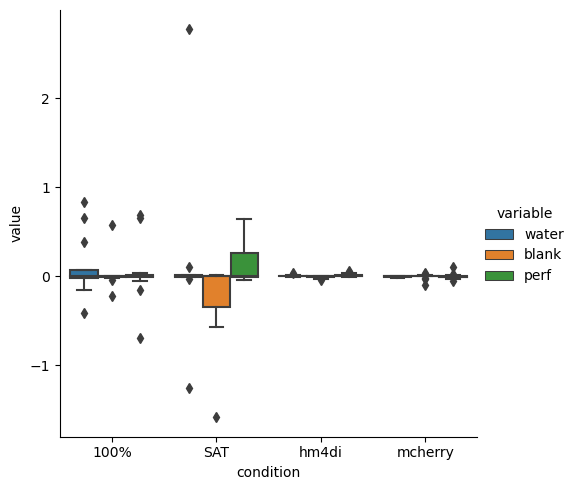

In [40]:
diffs = diffs.melt(id_vars=["condition", "animal"])
sns.catplot(diffs, x="condition", y="value", hue="variable", kind="box")

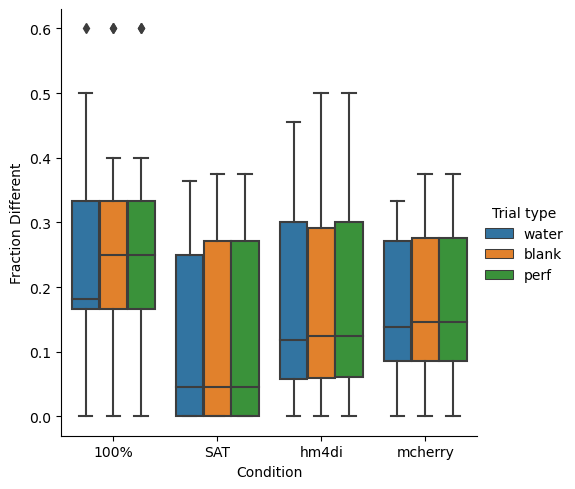

In [1138]:
fracdiffperf = fracdiffperf.reset_index().melt(id_vars=["condition", "animal"])
g = sns.catplot(fracdiffperf, x="condition", y="value",hue="variable", kind="box")
g.ax.set_ylabel("Fraction Different")
g.ax.set_xlabel("Condition")
g._legend.set_title("Trial type")

animals where 1 trial got put into a different timebin: MJN3 (6 to 10), GSB8 Caitlyn (-10 to -6), NDR1 (-14 to -18), NCY1 (-38 to -42), MYC4(-10 to -14)

animals where 1st timebin after air is different (my analysis has concat): NLV5, NLV3, NLV2, NLB8, NLG3, NLB1, NKZ3

add 24h: NLV5, NLV2, NLV3, NLN3, NLN5, NLB1, NLG3, NKZ4, 

dont: NLG3, NLB8, NLB10, NKZ7, NKZ4, NKZ3, NKZ10,

NaN rows: GKO6 Mason - 9; GSB8 Caitlyn - 4; GXC7 Bambi - 7;  MJN2 - 6; NDR1 - 1; MJL2 - 1; NKZ7 - 1; MKV11 - 2; NKZ10 - 1; LWP6 - 1; NFZ4 - 1; NIO16 - 1; MKV10 - 2; MZG5 - 1; NFZ13 - 1; GXS4 Khloe; MZG4 - 1; JSS4 - 1; NBE11 - 1; LWP2 - 1; NGX5 - 1

In [1139]:
licks = perf.rename(columns={("lick", "blank"):"blank",("lick", "water"):"water",("perf",""):"perf"}).melt(id_vars=["condition", "animal", "delta", "count"], value_vars=["water", "blank"], value_name="lick", var_name="trial type")
perf = v16_compare

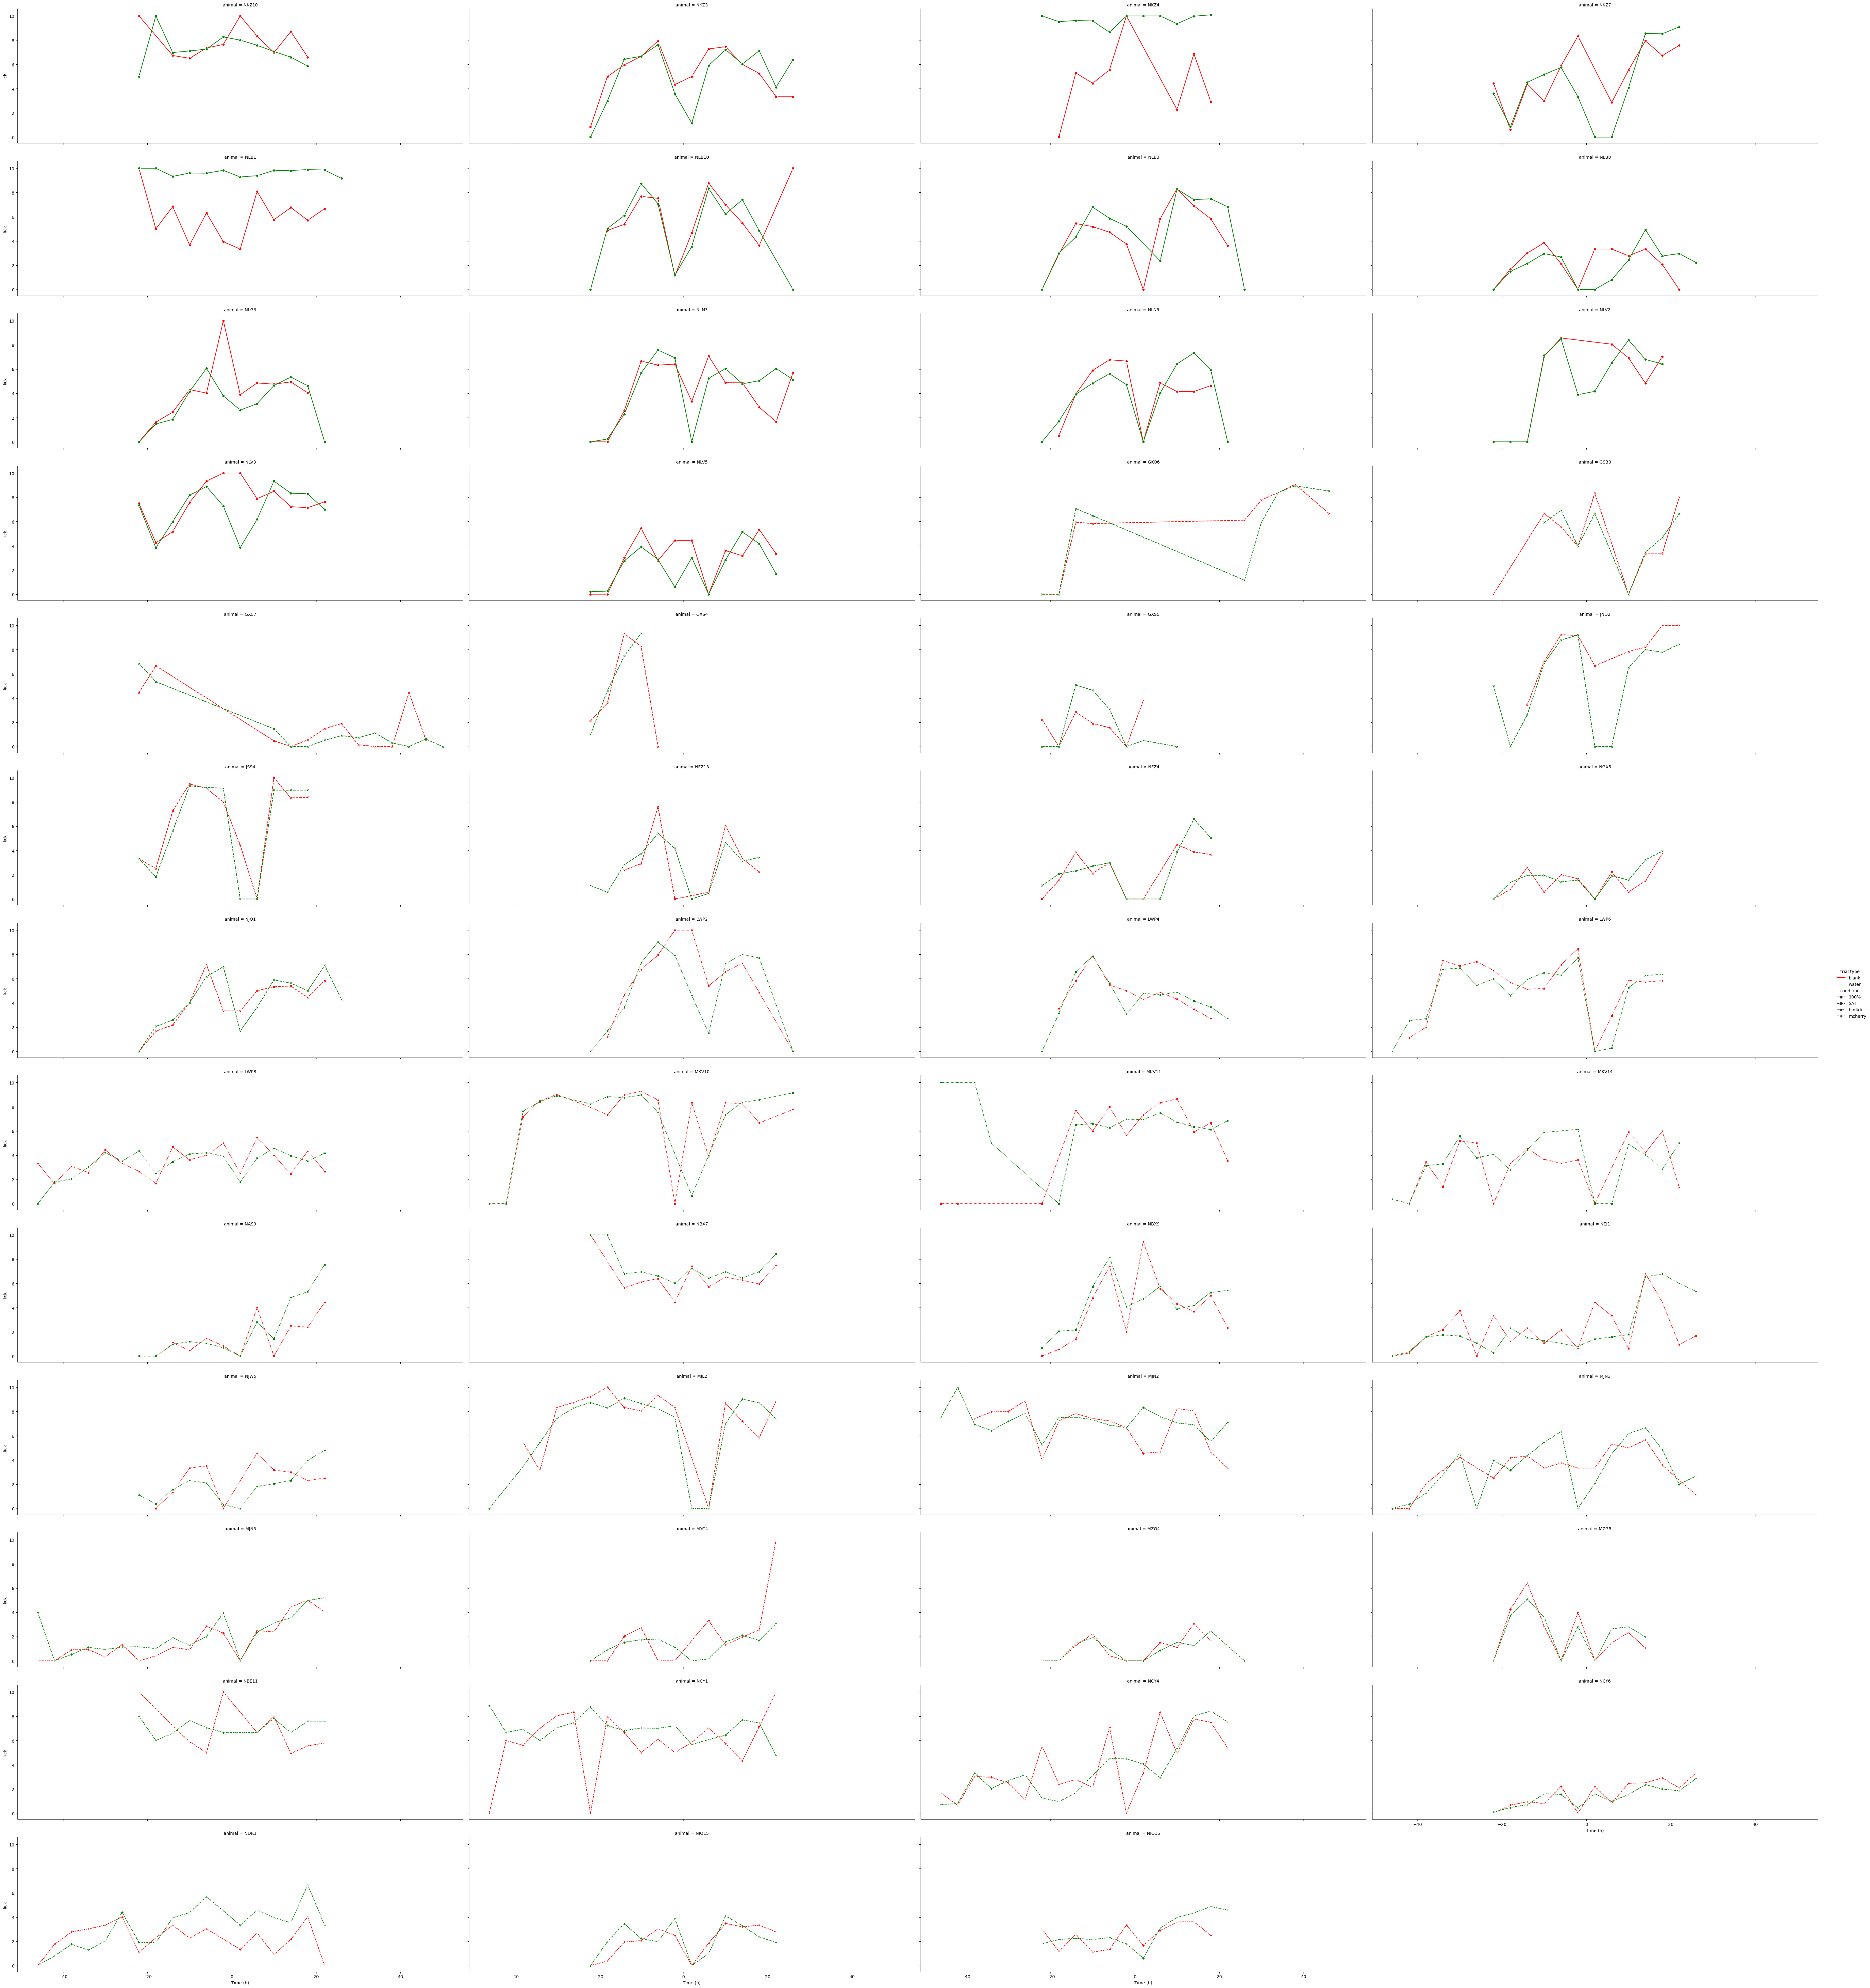

In [1140]:
#ancticipatory licking all animals
perf
g = sns.relplot(licks, x="delta", y="lick", kind="line", hue="trial type", col="animal", col_wrap=4, style="condition", aspect=3, markers=True,
                palette=["red", "green"], hue_order=["blank", "water"], errorbar=None)
for ax in g.axes.flat:
    ax.set_xlabel("Time (h)")
    

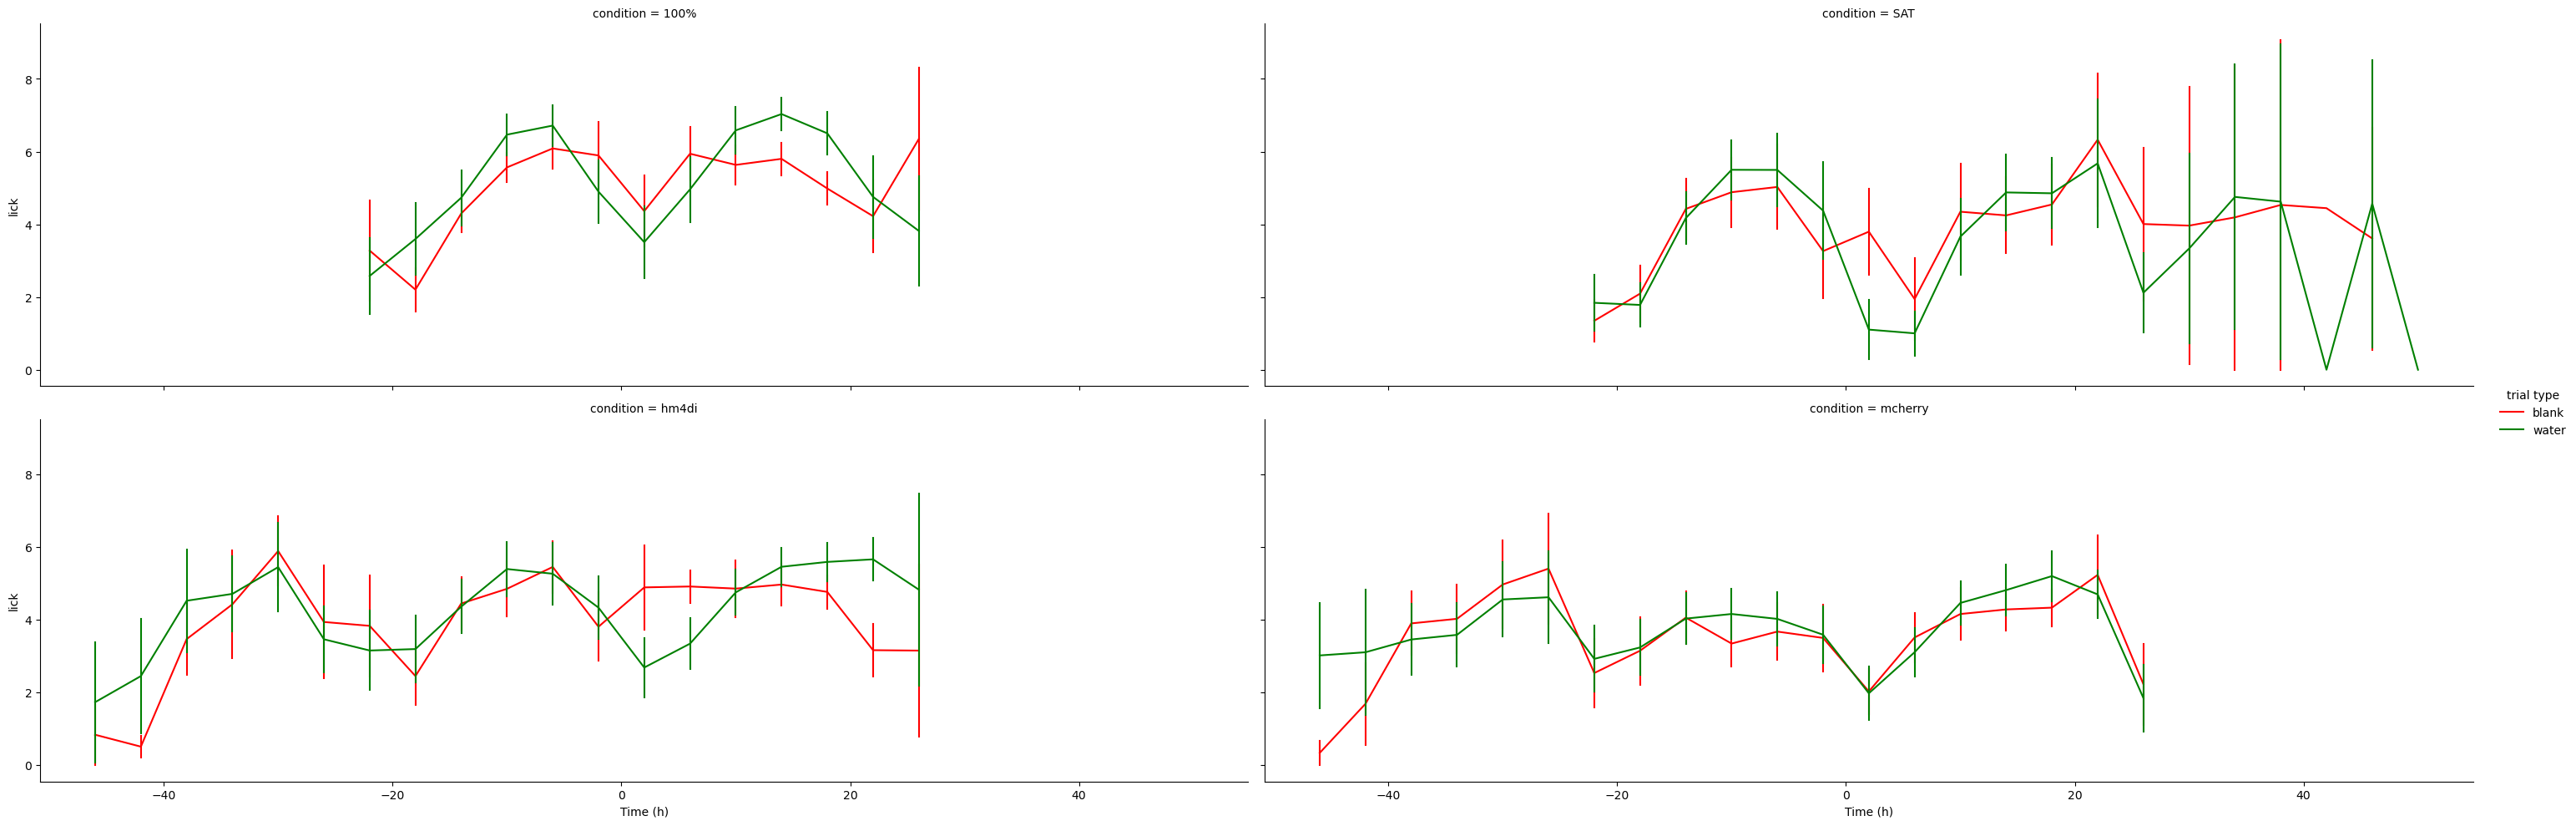

In [1141]:
#ancticipatory licking average by group
g = sns.relplot(licks, x="delta", y="lick", kind="line", hue="trial type", col="condition", col_wrap=2, aspect=3,
                palette=["red", "green"], hue_order=["blank", "water"], errorbar="se", err_style="bars")
for ax in g.axes.flat:
    ax.set_xlabel("Time (h)")
    

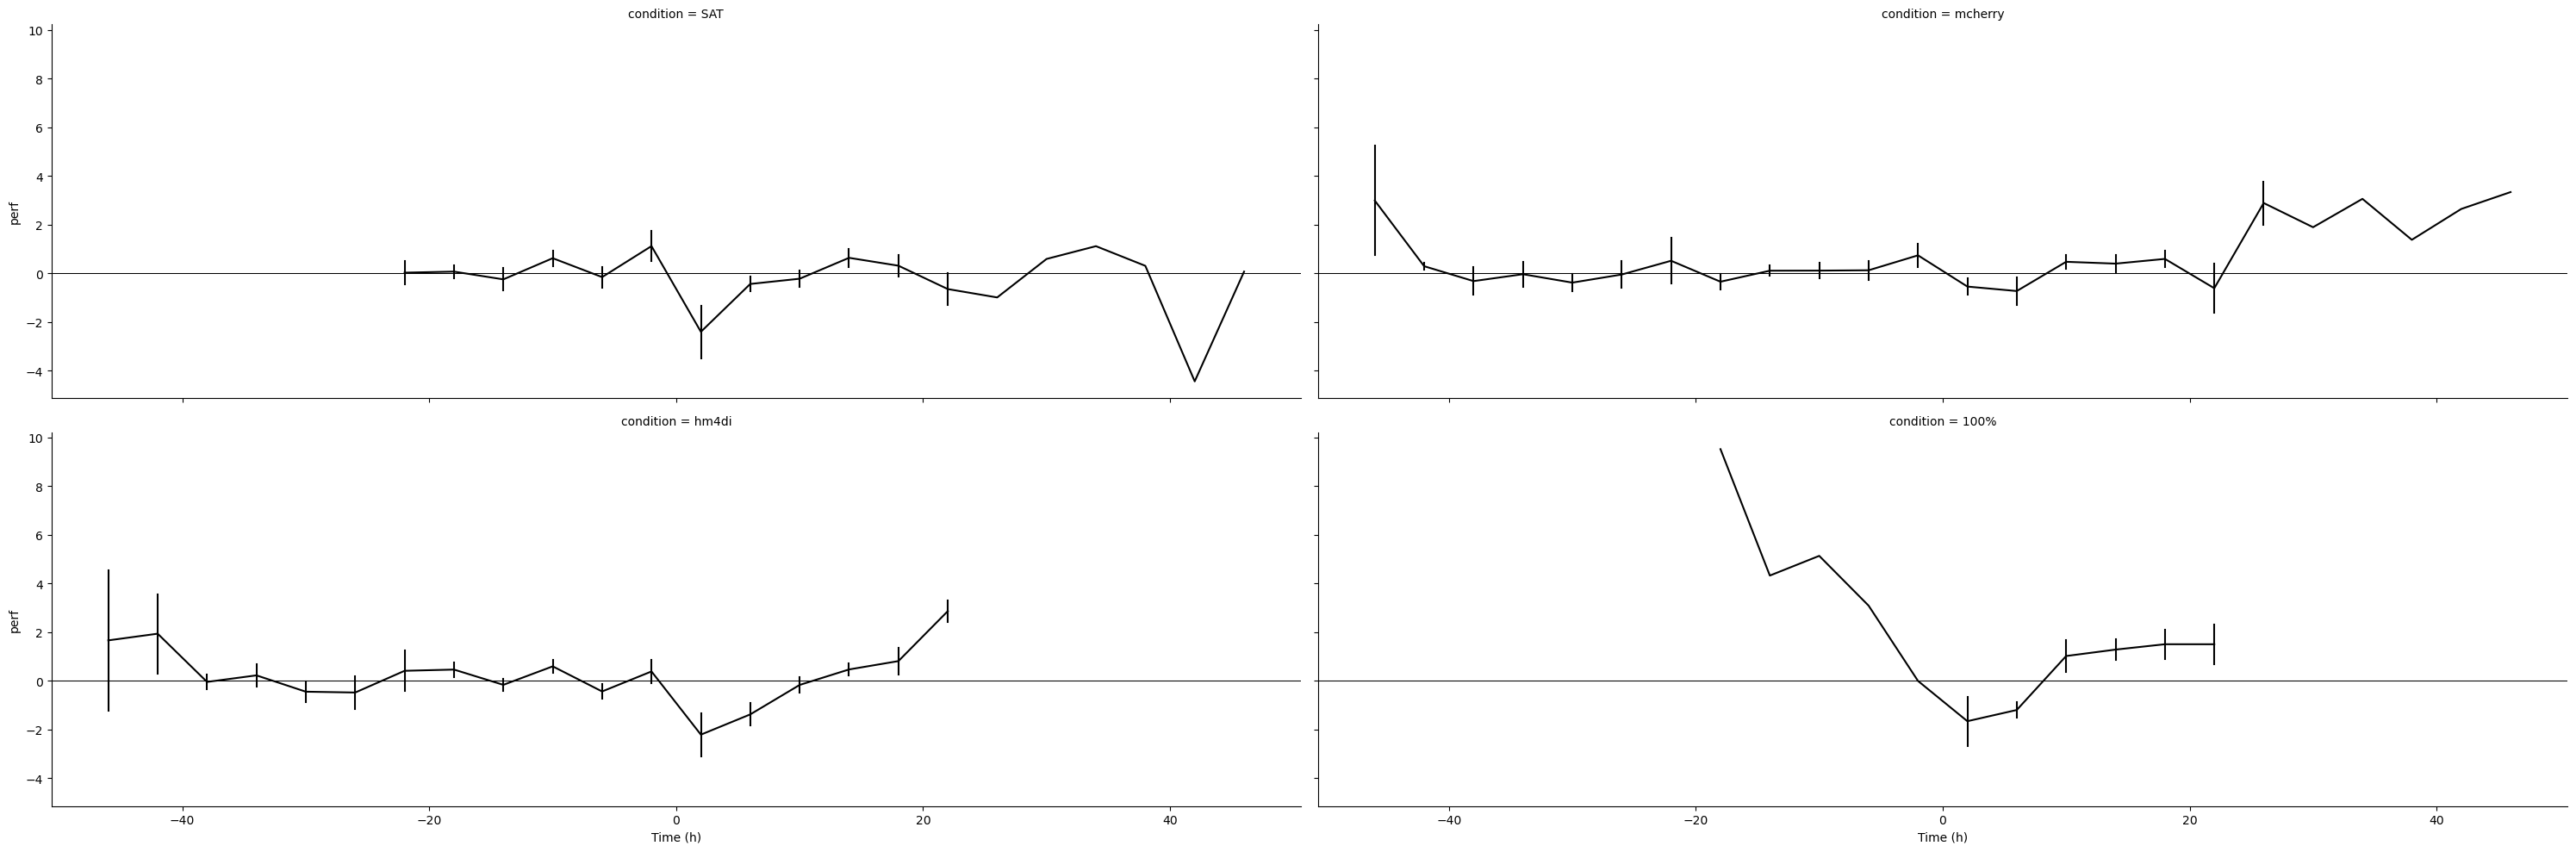

In [1142]:
#performance average by group
g = sns.relplot(perf, x="delta", y="perf", kind="line", col="condition", col_wrap=2, aspect=3,
                errorbar="se", err_style="bars", color='k')
for ax in g.axes.flat:
    ax.set_xlabel("Time (h)")
    ax.axhline(y=0, xmin=0, xmax=1, ls="-", lw=0.75,color="black", zorder=0)
    

In [1143]:
trials = aa.groupby(["condition", "animal", "trial no"]).first().reset_index()
trials["hour"] = pd.DatetimeIndex(trials.loc[:,"timestamp"]).hour 
acc = (trials["delta"] < pd.to_timedelta(0, unit="h")) & (trials["delta"] > pd.to_timedelta(-24, unit="h"))
sat = (trials["delta"] > pd.to_timedelta(0, unit="h")) & (trials["delta"] < pd.to_timedelta(24, unit="h"))
mask = (trials["hour"]> 20) | (trials["hour"] < 6)

darkacc = trials[mask & acc]
darksat = trials[mask & sat]
darkacc = darkacc.groupby(["condition", "animal"]).count()["trial no"].rename("dark")
darksat = darksat.groupby(["condition", "animal"]).count()["trial no"].rename("dark")

lightacc = trials[(~mask) & acc]
lightacc = lightacc.groupby(["condition", "animal"]).count()["trial no"].rename("light")
lightsat = trials[(~mask) & sat]
lightsat = lightsat.groupby(["condition", "animal"]).count()["trial no"].rename("light")

totalacc = trials[acc].groupby(["condition", "animal"]).count()["trial no"].rename("total")
totalsat = trials[sat].groupby(["condition", "animal"]).count()["trial no"].rename("total")

fracacc = (darkacc/totalacc).rename("fraction in dark")
fracsat =(darksat/totalsat).rename("fraction in dark")

trialnosacc = pd.concat([darkacc, lightacc, totalacc, fracacc], axis=1)
trialnossat = pd.concat([darksat, lightsat, totalsat, fracsat], axis=1)


In [1144]:
print("Average for Acclimation")
trialnosacc.groupby("condition").median()

Average for Acclimation


,dark,light,total,fraction in dark
condition,,,,
100%,218.0,147.0,334.5,0.664398
SAT,196.0,92.0,339.0,0.694444
hm4di,272.0,155.0,441.0,0.629951
mcherry,197.0,149.0,377.5,0.569737


In [1145]:
print("Average for SAT")
trialnossat.groupby("condition").mean()

Average for SAT


,dark,light,total,fraction in dark
condition,,,,
100%,385.714286,172.642857,558.357143,0.685972
SAT,261.666667,62.200000,297.700000,0.744587
hm4di,279.750000,160.666667,440.416667,0.628617
mcherry,238.642857,167.500000,406.142857,0.598225


In [1146]:
trialnosacc.groupby("condition").mean()

,dark,light,total,fraction in dark
condition,,,,
100%,304.857143,150.357143,455.214286,0.657684
SAT,226.090909,107.636364,333.727273,0.689749
hm4di,266.333333,151.916667,418.250000,0.638100
mcherry,214.428571,169.357143,383.785714,0.561156
